In [3]:
from main import get_preprocessed_data
from indicator_and_strategy.indicators import Indicator
from indicator_and_strategy.momentumstrategy import MomentumStrategy
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import talib
import datetime as dt

from finrl.meta.preprocessor.yahoodownloader import  YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS
import itertools


plt.style.use('ggplot')
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dollar PnL calculation

pnls = []
dates = []
entry = None
for i in range(len(df)):
    if df['emas'].iloc[i] > df['emal'].iloc[i] and df['emas'].iloc[i-1] < df['emal'].iloc[i-1]:
        if entry:
            pnl = entry - df['close'].iloc[i]
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Buy on {df.index[i]} and at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]

    elif df['emas'].iloc[i] < df['emal'].iloc[i] and df['emas'].iloc[i-1] > df['emal'].iloc[i-1]:
        if entry:
            pnl = df['close'].iloc[i] - entry
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Sell on {df.index[i]} at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]


# Percentage PnL calculation
pnls = []
dates = []
entry = None
for i in range(len(df)):
    if df['emas'].iloc[i] > df['emal'].iloc[i] and df['emas'].iloc[i-1] < df['emal'].iloc[i-1]:
        if entry:
            pnl = (entry - df['close'].iloc[i]) / entry
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Buy on {df.index[i]} and at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]


    elif df['emas'].iloc[i] < df['emal'].iloc[i] and df['emas'].iloc[i-1] > df['emal'].iloc[i-1]:
        if entry:
            pnl = (df['close'].iloc[i] - entry) / entry
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Sell on {df.index[i]} at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]

# Plotting Unrealized PnL 

entry = None
pnls = []
dates = []
inpos = 0
unrlzd = []
urlzd_dates = []
hold_time = []
for i in range(len(df)):
    unr = (spy.iloc[i] -spy.iloc[i - 1]) * inpos
    unrlzd.append(unr)
    urlzd_dates.append(df.index[i])
    hold_time.append((df['close'].index[i] - start).days)
    if df['emas'].iloc[i] > df['emal'].iloc[i] and df['emas'].iloc[i-1] < df['emal'].iloc[i-1]:
        if entry:
            pnl = entry - spy.iloc[i]
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Buy on {df.index[i]} and at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].index[i]
        inpos = 1
        start = df.index[i]

    elif df['emas'].iloc[i] < df['emal'].iloc[i] and df['emas'].iloc[i-1] > df['emal'].iloc[i-1]:
        if entry:
            pnl = spy.iloc[i] - entry
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Sell on {df.index[i]} at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]
        inpos = -1
        start = df['close'].index[i]

plt.figure(figsize=(16,8))
plt.title('Unrealized PnL vs Realized PnL')
plt.plot(urlzd_dates, np.cumsum(unrlzd))
plt.plot(dates, np.cumsum(pnls), '-o')


# Quantifying the strategy: How good is it?

sharp_ratio = np.mean(unrlzd) / np.std(unrlzd) * np.sqrt(252)
print(f'Annualized Sharpe Ratio: {sharp_ratio}')

sharp_ratio = np.mean(unrlzd) / np.std(unrlzd) * 16
print(f'Annualized Sharpe Ratio: {sharp_ratio}')

In [4]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2023-05-01'

In [5]:
symbols = [
    'aapl', 
    'msft',
    'meta',
    'ibm'
]

In [6]:
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = symbols
                     ).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (13569, 8)


In [7]:
df_raw.head(10)

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.740173,746015200,aapl,4
1,2009-01-02,80.200768,83.738052,80.200768,49.160149,7905877,ibm,4
2,2009-01-02,19.530001,20.400000,19.370001,15.011639,50084000,msft,4
3,2009-01-05,3.327500,3.435000,3.311071,2.855819,1181608400,aapl,0
4,2009-01-05,82.619499,83.814529,82.390060,48.850681,8698222,ibm,0
5,2009-01-05,20.200001,20.670000,20.059999,15.151946,61475200,msft,0
6,2009-01-06,3.426786,3.470357,3.299643,2.808713,1289310400,aapl,1
7,2009-01-06,83.279160,86.434036,82.571701,50.206703,10093377,ibm,1
8,2009-01-06,20.750000,21.000000,20.610001,15.329155,58083400,msft,1
9,2009-01-07,3.278929,3.303571,3.223571,2.748023,753048800,aapl,2


In [8]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)
df = fe.preprocess_data(df_raw)
df.head()

Successfully added technical indicators


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (3604, 8)
Successfully added vix
Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.740173,746015200,aapl,4,0.000000,2.961544,2.634448,100.0,66.666667,100.0,2.740173,2.740173,39.189999,0.0
1,2009-01-02,80.200768,83.738052,80.200768,49.160149,7905877,ibm,4,0.000000,2.961544,2.634448,100.0,66.666667,100.0,49.160149,49.160149,39.189999,0.0
2,2009-01-02,19.530001,20.400000,19.370001,15.011639,50084000,msft,4,0.000000,2.961544,2.634448,100.0,66.666667,100.0,15.011639,15.011639,39.189999,0.0
3,2009-01-05,3.327500,3.435000,3.311071,2.855819,1181608400,aapl,0,0.002595,2.961544,2.634448,100.0,66.666667,100.0,2.797996,2.797996,39.080002,0.0
4,2009-01-05,82.619499,83.814529,82.390060,48.850681,8698222,ibm,0,-0.006943,49.443068,48.567762,0.0,66.666667,100.0,49.005415,49.005415,39.080002,0.0


In [9]:
list_ticker = df['tic'].unique().tolist()
list_date = list(pd.date_range(df['date'].min(), df['date'].max()).astype(str))
combination = list(itertools.product(list_date, list_ticker))

procesed_df = pd.DataFrame(combination, columns=['date', 'tic']).merge(df, on=['date', 'tic'], how='left')
procesed_df = procesed_df[procesed_df['date'].isin(df['date'])]
procesed_df = procesed_df.sort_values(['date', 'tic'])
procesed_df = procesed_df.fillna(0)


In [10]:
procesed_df.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,aapl,3.067143,3.251429,3.041429,2.740173,7.460152e+08,4.0,0.000000,2.961544,2.634448,100.0,66.666667,100.0,2.740173,2.740173,39.189999,0.0
1,2009-01-02,ibm,80.200768,83.738052,80.200768,49.160149,7.905877e+06,4.0,0.000000,2.961544,2.634448,100.0,66.666667,100.0,49.160149,49.160149,39.189999,0.0
2,2009-01-02,msft,19.530001,20.400000,19.370001,15.011639,5.008400e+07,4.0,0.000000,2.961544,2.634448,100.0,66.666667,100.0,15.011639,15.011639,39.189999,0.0
9,2009-01-05,aapl,3.327500,3.435000,3.311071,2.855819,1.181608e+09,0.0,0.002595,2.961544,2.634448,100.0,66.666667,100.0,2.797996,2.797996,39.080002,0.0
10,2009-01-05,ibm,82.619499,83.814529,82.390060,48.850681,8.698222e+06,0.0,-0.006943,49.443068,48.567762,0.0,66.666667,100.0,49.005415,49.005415,39.080002,0.0


In [11]:
train = data_split(procesed_df, TRAIN_START_DATE, TRAIN_END_DATE)
trade = data_split(procesed_df, TRADE_START_DATE, TRADE_END_DATE)

print(len(train))
print(len(trade))


8679
2133


In [12]:
from pathlib import Path

In [18]:
train.to_csv(Path.cwd() / 'train.csv')
trade.to_csv(Path.cwd() / 'trade.csv')

In [19]:
# Traing part of Finrl:

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR

check_and_make_directories([TRAINED_MODEL_DIR])

In [29]:

stock_dimension = len(train.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f'Number of Stock: {stock_dimension} || State Space: {state_space}')

Number of Stock: 3 || State Space: 31


In [36]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

In [52]:
env_kwargs = {
    'hmax': 100,    # the maximum number of shares that can be purchased at each step
    'initial_amount': 1000000, 
    'num_stock_shares': num_stock_shares,
    'buy_cost_pct': buy_cost_list,
    'sell_cost_pct': sell_cost_list,
    'state_space': state_space,
    'stock_dim': stock_dimension,
    'tech_indicator_list': INDICATORS,
    'action_space': stock_dimension,
    'reward_scaling': 1e-4
}

e_train_gym = StockTradingEnv(df=train, **env_kwargs)   # This is state-space representation of the env


In [53]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [61]:
agent = DRLAgent(env = env_train)

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = False
if_using_ddpg = False
if_using_dqn = False
if_using_a2c = False
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False
if_using_dqn = False
if_using_a2c = True
if_using_ddpg = False

In [62]:
model_a2c = agent.get_model("a2c")
model_ppo = agent.get_model("ppo")

if if_using_a2c:
    tmp_path = TRAINED_MODEL_DIR + 'a2c'
    new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_a2c.set_logger(new_logger_a2c)

if if_using_dqn:
    tmp_path = TRAINED_MODEL_DIR + 'ppo'
    new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_a2c.set_logger(new_logger_ppo)

    

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to trained_modelsa2c


In [65]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=500000) if if_using_a2c else None

---------------------------------------
| time/                 |             |
|    fps                | 587         |
|    iterations         | 100         |
|    time_elapsed       | 0           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -4.5        |
|    explained_variance | 0.209       |
|    learning_rate      | 0.0007      |
|    n_updates          | 10099       |
|    policy_loss        | -2.43       |
|    reward             | 0.075249605 |
|    std                | 1.09        |
|    value_loss         | 0.399       |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 578       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -4.48     |
|    explained_variance | 0.185     |
|    learning_rate

In [66]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(model=trained_a2c, 
                        environment = e_train_gym)

hit end!


<Axes: >

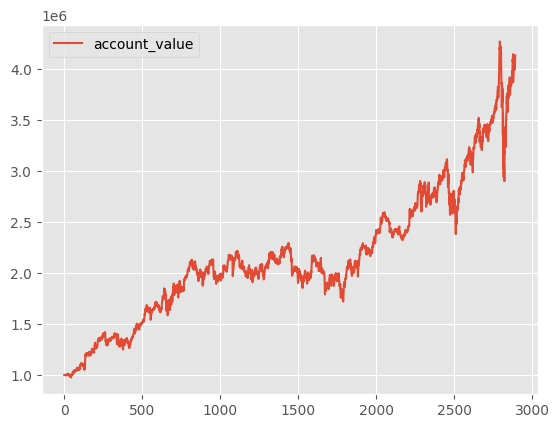

In [71]:
df_account_value_a2c.plot()


In [86]:
len(df_actions_a2c[df_actions_a2c['inm'] >= 100 ])

0

In [81]:
df_actions_a2c

,aapl,ibm,msft
date,,,
2009-01-02,0,100,100
2009-01-05,0,100,100
2009-01-06,0,100,100
2009-01-07,0,100,100
2009-01-08,0,100,100
...,...,...,...
2020-06-23,0,0,0
2020-06-24,0,0,0
2020-06-25,0,0,0


In [136]:
import ccxt
import datetime as dt
import pandas as pd
ex = ccxt.binance()

df_rrw = ex.fetch_ohlcv('BTC/USDT', '1d', since=1496787634826, limit=100000)

In [150]:
df = pd.DataFrame(df_rrw, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['date'], unit='ms')
df.set_index(df['date'], inplace=True)
df.head()

,date,open,high,low,close,volume
date,,,,,,
2017-08-17,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060


In [166]:
sliced_df = df.loc['2018-01-01':]

<Axes: xlabel='date'>

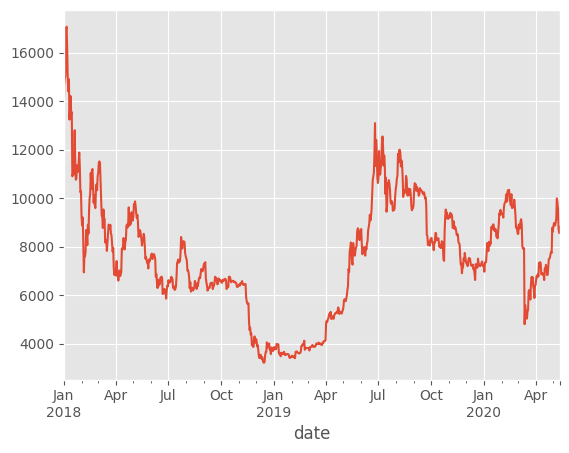

In [168]:
sliced_df['close'].plot()

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='date'>

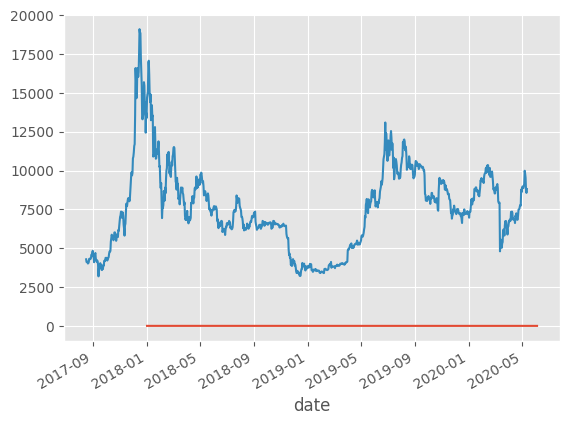

In [177]:
import yfinance as yf

# Download data for US Federal Funds Rate
fed_funds_data = yf.download("^IRX", start="2018-01-01", end="2020-06-05")

# Access closing prices (daily interest rates)
daily_rates = fed_funds_data["Close"]

# Print the first few daily rates
daily_rates.plot()
df['close'].plot()

In [189]:
close_price = np.array(df['close']).reshape(-1,1)

In [190]:
from sklearn.preprocessing import MinMaxScaler
preprocessor = MinMaxScaler()
df['close_scaled'] = preprocessor.fit_transform(close_price)


<Axes: xlabel='date'>

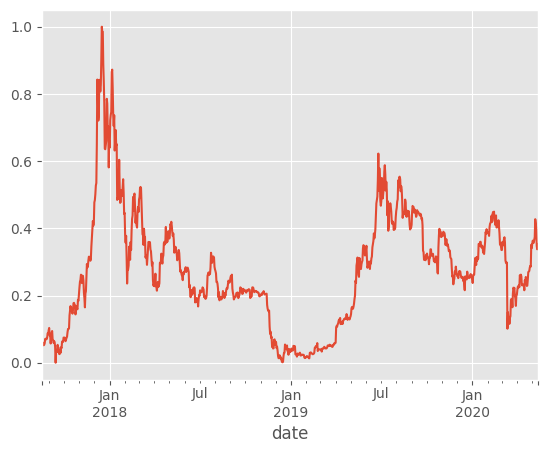

In [191]:
df['close_scaled'].plot()

In [176]:
sliced_df = df.loc['2018-01-01':]
sliced_df


,date,open,high,low,close,volume
date,,,,,,


<Axes: xlabel='date'>

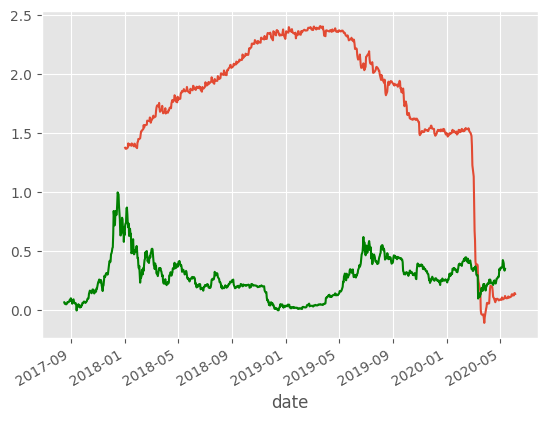

In [193]:
daily_rates.plot()
df['close_scaled'].plot( color='green')

In [194]:
import requests
import pandas as pd

# Define the API endpoint and parameters
api_url = "https://api.example.com/ftse-global-digital-asset-index"
params = {
    'index': 'FTSE_GLOBAL_DIGITAL_ASSET_50',
    'start_date': '2023-01-01',
    'end_date': '2023-12-31'
}

# Fetch the data
response = requests.get(api_url, params=params)
data = response.json()

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data['prices'])
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Display the DataFrame
print(df.head())


ConnectionError: HTTPSConnectionPool(host='api.example.com', port=443): Max retries exceeded with url: /ftse-global-digital-asset-index?index=FTSE_GLOBAL_DIGITAL_ASSET_50&start_date=2023-01-01&end_date=2023-12-31 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001712601E890>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [199]:
import requests
import json

try:
  # Your code to fetch data (replace with your actual API call)
  response = requests.get("https://api.example.com/ftse-global-digital-asset-index")
  data = response.json()  # This line might raise the JSONDecodeError

  # Process the data here (assuming it's valid JSON)
  print(data["key"])  # Access data from the JSON object

except Exception as e:
  print("Error: Could not parse JSON data!")
  print(f"Reason: {e}")  # Print the error message for debugging


Error: Could not parse JSON data!
Reason: HTTPSConnectionPool(host='api.example.com', port=443): Max retries exceeded with url: /ftse-global-digital-asset-index (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000171279A9BA0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))


In [204]:
import requests
import json
from json import JSONDecodeError

try:
  response = requests.get("https://pro-api.coinmarketcap.com/v1/global-metrics/quotes/historical")
  data = response.json()  # This line might raise the JSONDecodeError or other exceptions

  # Process the data here (assuming it's valid JSON)
  print(data)  # Access data from the JSON object

except requests.exceptions.RequestException as e:
  # Handle different request exceptions
  if isinstance(e, requests.exceptions.ConnectionError):
    print("Error: Could not connect to the API server!")
    print(f"Reason: {e}")  # Print the connection error details
  elif isinstance(e, requests.exceptions.Timeout):
    print("Error: API request timed out!")
  else:
    print(f"An error occurred while making the API request: {e}")

except JSONDecodeError as e:
  print("Error: Could not parse JSON data!")
  print(f"Reason: {e}")  # Print the JSON parsing error for debugging


{'status': {'timestamp': '2024-06-05T16:20:05.848Z', 'error_code': 1002, 'error_message': 'API key missing.', 'elapsed': 0, 'credit_count': 0}}


In [211]:
def global_var():
    global new_var 
    new_var = 4; 
    return new_var 

# global_var()

In [212]:
global_var(15)

4

In [213]:

class MyClass:
    class_var = 10  # Class variable (shared)

    def __init__(self, value):
        self.instance_var = value  # Instance variable

    def some_method(self):
        print("Class variable:", MyClass.class_var)  # No `global` needed
        print("Class attribute:", MyClass.shared_data)  # No `global` needed
        print("Instance variable:", self.instance_var)

# Set class-level attribute
MyClass.shared_data = "Global value"

obj1 = MyClass(20)
obj2 = MyClass(30)

obj1.some_method()
obj2.some_method()


Class variable: 10
Class attribute: Global value
Instance variable: 20
Class variable: 10
Class attribute: Global value
Instance variable: 30


In [215]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Define the neural network model
model = Sequential()

# Input layer (flattening the input)
model.add(Flatten(input_shape=(6, 16)))  # 6 time steps, 16 features per time step

# Hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))

# Output layer (example with a single output, e.g., future price or action value)
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Display the model summary
model.summary()


d:\RL-Project\Py310-venv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,057 (113.50 KB)

 Trainable params: 29,057 (113.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def traditional_opportunity_cost(current_balance, initial_balance, max_steps, current_step):
  """
  Calculates opportunity cost based on traditional definition.

  Args:
      current_balance (float): The current account balance.
      initial_balance (float): The initial account balance.
      max_steps (int): The maximum number of steps (e.g., investment period).
      current_step (int): The current step in the investment period.

  Returns:
      float: The opportunity cost.
  """

  # Check for zero initial balance to avoid division by zero
  if initial_balance == 0:
    return 0

  # Calculate the potential return if invested elsewhere
  potential_return = (max_steps - current_step) * (current_balance - initial_balance) / initial_balance

  return potential_return



def custom_opportunity_cost(current_balance, max_steps, current_step):
  """
  Calculates opportunity cost based on the custom definition.

  Args:
      current_balance (float): The current account balance.
      max_steps (int): The maximum number of steps (e.g., investment period).
      current_step (int): The current step in the investment period.

  Returns:
      float: The opportunity cost.
  """

  # Avoid division by zero
  if current_step == 0:
    return 0

  return current_balance * current_step / max_steps


In [3]:
import pandas as pd
import requests
import numpy as np

# Function to fetch data from FRED API
def fetch_interest_rate_data(api_key, series_id, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date,
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code}")
    data = response.json()
    if 'observations' not in data:
        raise KeyError("'observations' not found in the API response")
    observations = data['observations']
    dates = [obs['date'] for obs in observations]
    values = [float(obs['value']) for obs in observations]
    return pd.DataFrame({'date': dates, 'interest_rate': values})

# Your FRED API key
api_key = '8b04ec256d29b1e56af63386ba61ebe1'
series_id = 'DFF'  # This is the FRED series ID for the Federal Funds Rate
start_date = '2018-01-01'
end_date = '2023-12-31'

try:
    # Fetch the interest rate data
    interest_rate_df = fetch_interest_rate_data(api_key, series_id, start_date, end_date)
    interest_rate_df['date'] = pd.to_datetime(interest_rate_df['date'])
    interest_rate_df.set_index('date', inplace=True)
except KeyError as e:
    print(f"KeyError: {e}")
except Exception as e:
    print(f"Error: {e}")


print(interest_rate_df)
# Assume you already have your daily OHLC data in a DataFrame called ohlc_df
# Example OHLC DataFrame structure
ohlc_df = pd.DataFrame({
    'date': pd.date_range(start='2018-01-01', end='2023-12-31', freq='B'),
    'open': 100 + np.random.randn(1516).cumsum(),
    'high': 100 + np.random.randn(1516).cumsum(),
    'low': 100 + np.random.randn(1516).cumsum(),
    'close': 100 + np.random.randn(1516).cumsum()
})
ohlc_df['date'] = pd.to_datetime(ohlc_df['date'])
ohlc_df.set_index('date', inplace=True)

if 'interest_rate_df' in locals():
    # Merge and backfill the interest rate data to match the OHLC data frequency
    merged_df = ohlc_df.merge(interest_rate_df, left_index=True, right_index=True, how='left')
    merged_df['interest_rate'].fillna(method='bfill', inplace=True)

    # Display the merged DataFrame
    print(merged_df.head(10))
else:
    print("Interest rate data was not successfully fetched.")


            interest_rate
date                     
2018-01-01           1.33
2018-01-02           1.42
2018-01-03           1.42
2018-01-04           1.42
2018-01-05           1.42
...                   ...
2023-12-27           5.33
2023-12-28           5.33
2023-12-29           5.33
2023-12-30           5.33
2023-12-31           5.33

[2191 rows x 1 columns]


In [ ]:
import pandas as pd
import requests
import numpy as np

# Function to fetch data from FRED API
def fetch_interest_rate_data(api_key, series_id, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date,
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code}")
    data = response.json()
    if 'observations' not in data:
        raise KeyError("'observations' not found in the API response")
    observations = data['observations']
    dates = [obs['date'] for obs in observations]
    values = [float(obs['value']) for obs in observations]
    return pd.DataFrame({'date': dates, 'interest_rate': values})

# Your FRED API key
api_key = '8b04ec256d29b1e56af63386ba61ebe1'
series_id = 'DFF'  # This is the FRED series ID for the Federal Funds Rate
start_date = '2018-01-01'
end_date = '2023-12-31'

try:
    # Fetch the interest rate data
    interest_rate_df = fetch_interest_rate_data(api_key, series_id, start_date, end_date)
    interest_rate_df['date'] = pd.to_datetime(interest_rate_df['date'])
    interest_rate_df.set_index('date', inplace=True)
except KeyError as e:
    print(f"KeyError: {e}")
except Exception as e:
    print(f"Error: {e}")


print(interest_rate_df)


            interest_rate
date                     
2018-01-01           1.33
2018-01-02           1.42
2018-01-03           1.42
2018-01-04           1.42
2018-01-05           1.42
...                   ...
2023-12-27           5.33
2023-12-28           5.33
2023-12-29           5.33
2023-12-30           5.33
2023-12-31           5.33

[2191 rows x 1 columns]


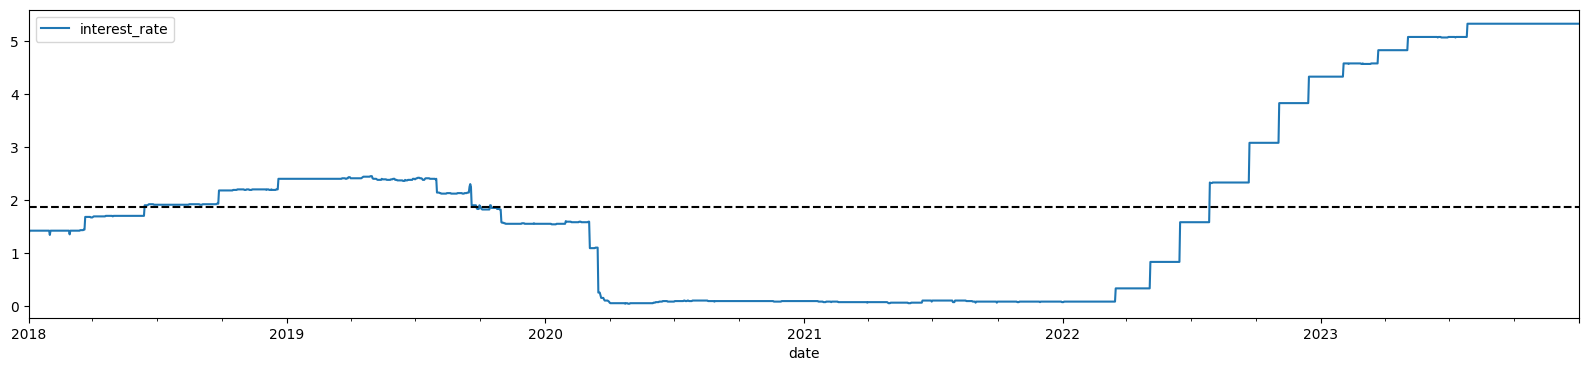

In [17]:
interest_rate_df.plot(figsize=(20,4))
import matplotlib.pyplot as plt
plt.axhline(y=interest_rate_df['interest_rate'].values.mean(), color='black', linestyle='--')

[*********************100%%**********************]  1 of 1 completed


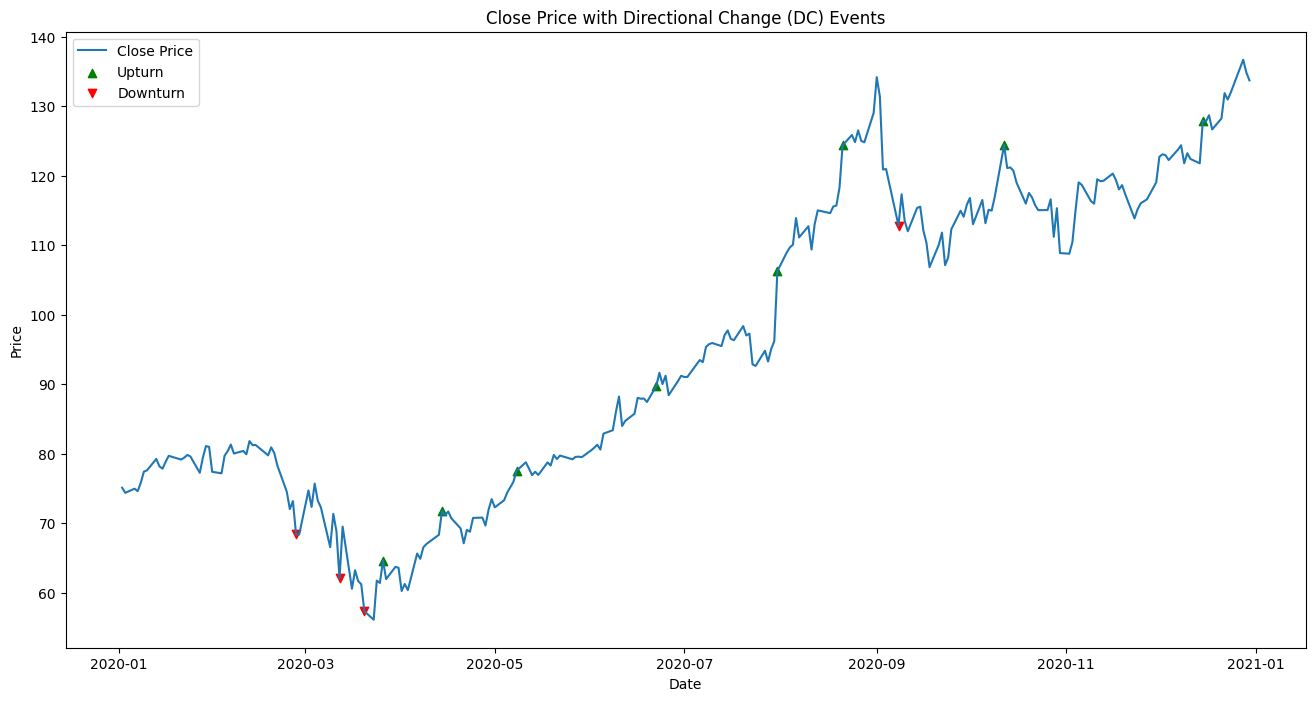

In [25]:
import yfinance as yf
import matplotlib.pyplot as plt

def detect_dc_events(prices, threshold):
    dc_events = []
    peak = prices[0]
    trough = prices[0]
    last_dc = None
    for i, price in enumerate(prices):
        if price >= peak:
            peak = price
            if (peak - trough) / trough >= threshold:
                dc_events.append(('Upturn', i, price))
                last_dc = 'Upturn'
                trough = peak
        elif price <= trough:
            trough = price
            if (peak - trough) / peak >= threshold:
                dc_events.append(('Downturn', i, price))
                last_dc = 'Downturn'
                peak = trough
    return dc_events

df = yf.download('AAPL', start='2020-01-01', end='2020-12-31')
prices = df['Close'].values
threshold = 0.15
dc_events = detect_dc_events(prices, threshold)

# Separate events into timestamps and prices
event_dates = [df.index[event[1]] for event in dc_events]
event_prices = [event[2] for event in dc_events]
event_types = [event[0] for event in dc_events]

# Plotting the close prices and DC events
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price')

# Plotting upturns and downturns with different colors
upturn_dates = [event_dates[i] for i in range(len(event_dates)) if event_types[i] == 'Upturn']
upturn_prices = [event_prices[i] for i in range(len(event_prices)) if event_types[i] == 'Upturn']
downturn_dates = [event_dates[i] for i in range(len(event_dates)) if event_types[i] == 'Downturn']
downturn_prices = [event_prices[i] for i in range(len(event_prices)) if event_types[i] == 'Downturn']

plt.scatter(upturn_dates, upturn_prices, color='green', marker='^', label='Upturn')
plt.scatter(downturn_dates, downturn_prices, color='red', marker='v', label='Downturn')

plt.title('Close Price with Directional Change (DC) Events')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [1]:
from icecream import ic

In [26]:
ic(interest_rate_df['interest_rate'].values.mean())

NameError: name 'interest_rate_df' is not defined

In [3]:
print(foo('123'))

NameError: name 'foo' is not defined

In [2]:
print("foo('123')", foo('123'))

NameError: name 'foo' is not defined

In [1]:
from icecream import ic

def foo(i):
    return i + 333

ic(foo(123))

ic| foo(123): 456


456

In [2]:
d = {'key': {1: 'one'}}
ic(d['key'][1])

class klass():
    attr = 'yep'
ic(klass.attr)

ic| d['key'][1]: 'one'
ic| klass.attr: 'yep'


'yep'

In [3]:
def foo():
    print(0)
    first()

    if expression:
        print(1)
        second()
    else:
        print(2)
        third()

foo()

0


NameError: name 'first' is not defined

In [24]:
import random 

In [39]:
import numpy as np

np.random()

TypeError: 'module' object is not callable

In [61]:
np.random.random([5,2])


array([[0.84285542, 0.35887187],
       [0.82439832, 0.49185069],
       [0.42440946, 0.41856043],
       [0.33268943, 0.62471114],
       [0.2086117 , 0.50295085]])

In [ ]:
import finrl 
from finrl import config 
from finrl.config_tickers import DOW_30_TICKER




In [62]:
from argparse import ArgumentParser 

In [3]:
import argparse

# Create an ArgumentParser object
parser = argparse.ArgumentParser(description="My Script Description")

# Add a positional argument (required)
parser.add_argument("positional_arg", help="This is a required argument")

# Add an optional argument with a default value
parser.add_argument("--optional_arg", default="default_value", help="This is an optional argument")

# Parse the arguments from sys.argv
args = parser.parse_args()

# Access the arguments
print("Positional argument:", args.positional_arg)
print("Optional argument:", args.optional_arg)


usage: ipykernel_launcher.py [-h] [--optional_arg OPTIONAL_ARG] positional_arg
ipykernel_launcher.py: error: the following arguments are required: positional_arg


SystemExit: 2

In [4]:
parser.add_argument("-f", "--file", type=str, required=True, help="Path to a file")
parser.add_argument("-n", "--number", type=int, default=10, help="An integer value")


_StoreAction(option_strings=['-n', '--number'], dest='number', nargs=None, const=None, default=10, type=<class 'int'>, choices=None, help='An integer value', metavar=None)

In [5]:
import argparse

def main():
    parser = argparse.ArgumentParser(description="Algorithmic Trading Script")
    
    parser.add_argument('--symbol', type=str, required=True, help='Stock symbol to trade')
    parser.add_argument('--start-date', type=str, required=True, help='Start date in YYYY-MM-DD format')
    parser.add_argument('--end-date', type=str, required=True, help='End date in YYYY-MM-DD format')
    parser.add_argument('--strategy', type=str, required=True, choices=['mean_reversion', 'momentum'], help='Trading strategy to use')
    parser.add_argument('--capital', type=float, default=10000, help='Initial capital in USD')

    args = parser.parse_args()
    
    # Now you can use args.symbol, args.start_date, args.end_date, args.strategy, and args.capital in your trading logic
    print(f"Trading {args.symbol} from {args.start_date} to {args.end_date} using {args.strategy} strategy with ${args.capital} capital.")
    
    # Example of using these arguments in trading logic
    # perform_trading(symbol=args.symbol, start_date=args.start_date, end_date=args.end_date, strategy=args.strategy, capital=args.capital)

if __name__ == "__main__":
    main()


usage: ipykernel_launcher.py [-h] --symbol SYMBOL --start-date START_DATE
                             --end-date END_DATE --strategy
                             {mean_reversion,momentum} [--capital CAPITAL]
ipykernel_launcher.py: error: the following arguments are required: --symbol, --start-date, --end-date, --strategy


SystemExit: 2

In [13]:
import yfinance as yf
def yahoo_downloader(symbol='AAPL', **kwargs):

    recognize_params = ['start_date', 'end_date', 'interval']

    start_date = kwargs.get('start_date', '2019-01-01')
    end_date = kwargs.get('end_date', '2020-12-31')
    interval = kwargs.get('interval', '1d')
    
    for key in kwargs:
        if key not in recognize_params:
            print(f"Invalid parameter: {key} with value {kwargs[key]}")

    data = yf.download(symbol, start=start_date, end=end_date, interval=interval)
    return data

yahoo_downloader('AAPL', name='ahmed').head(3)

[*********************100%%**********************]  1 of 1 completed

Invalid parameter: name with value ahmed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.845047,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.075397,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.530052,234428400


In [1]:
import pandas as pd, numpy as np, yfinance as yf
import datetime as dt

In [24]:
index = pd.date_range(start='2016-01-01', end='2023-12-31', freq='B')
val = np.random.randn(len(index))

# Create the initial dataset with business days
dataset = pd.DataFrame({
    'date': index,
    'value': val
})

# Generate a full date range for the entire year
full_index = pd.date_range(start='2016-01-01', end='2023-12-31', freq='D')

# Reindex the dataset to the full date range
# dataset = dataset.set_index('date').reindex(full_index).rename_axis('date').reset_index()
# dataset = dataset[~((dataset['date'].dt.month == 2) & (dataset['date'].dt.day == 29))]

dataset = dataset.set_index('date').reindex(full_index).rename_axis('date')

# Exclude the leap day (2020-02-29)
dataset = dataset[~((dataset.index.month == 2) & (dataset.index.day == 29))]
dataset


,value
date,
2016-01-01,0.067894
2016-01-02,NaN
2016-01-03,NaN
2016-01-04,-0.618992
2016-01-05,0.646289
...,...
2023-12-27,-1.170088
2023-12-28,0.827327
2023-12-29,1.268497


In [113]:
df = yf.download('BTC-USD', start='2016-01-01', end='2023-12-31', interval='1D')
df.reset_index(inplace=True)
full_index = pd.date_range(start='2016-01-01', end='2023-12-31', freq='D')
df = df.set_index('Date').reindex(full_index).rename_axis('Date')
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
df = df[~((df.index.month == 2) & (df.index.day == 29))]
df['Year'] = df.index.year
print(len(df))
print(df['Year'].value_counts())
print(df.isna().sum())
print(df.duplicated().sum())

[*********************100%%**********************]  1 of 1 completed

2920
Year
2016    365
2017    365
2018    365
2019    365
2020    365
2021    365
2022    365
2023    365
Name: count, dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Year         0
dtype: int64
1



C:\Users\razaa\AppData\Local\Temp\ipykernel_19920\3769557020.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\razaa\AppData\Local\Temp\ipykernel_19920\3769557020.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [115]:
df = yf.download('AAPL', start='2016-01-01', end='2023-12-31', interval='1D')
df.reset_index(inplace=True)
full_index = pd.date_range(start='2016-01-01', end='2023-12-31', freq='B')
df = df.set_index('Date').reindex(full_index).rename_axis('Date')
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
df = df[~((df.index.month == 2) & (df.index.day == 29))]
df['Year'] = df.index.year
print(len(df))
print(df['Year'].value_counts())
print(df.isna().sum())
print(df.duplicated().sum())

[*********************100%%**********************]  1 of 1 completed

2085
Year
2020    262
2018    261
2019    261
2021    261
2016    260
2017    260
2022    260
2023    260
Name: count, dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Year         0
dtype: int64
68



C:\Users\razaa\AppData\Local\Temp\ipykernel_19920\1887837775.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\razaa\AppData\Local\Temp\ipykernel_19920\1887837775.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [2]:
import yfinance as yf
import pandas as pd, numpy as np, datetime as dt 
import talib as ta
import time, timeit
from tqdm import tqdm

In [287]:
def yahoo_downloader(symbol: str = 'AAPL', **kwargs):
    """
    Downloads historical price data from Yahoo Finance for a given symbol.
    """
    start_date = kwargs.get('start_date', '2015-01-01')
    end_date = kwargs.get('end_date', '2023-12-31')
    intervel = kwargs.get('interval', '1d')

    data = yf.download(symbol, start=start_date, end=end_date, interval=intervel) 
    
    return data


def preprocessor(df: pd.DataFrame, **kwargs):
    """
    Preprocesses the data by calculating technical indicators and filling missing values.
    """
    # Calculate technical indicators
    df = df.reset_index()
    full_index = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    df = df.set_index('Date').reindex(full_index).rename_axis('Date')
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    df = df[~((df.index.month == 2) & (df.index.day == 29))]
    df['Year'] = df.index.year
    return df 


df1 = preprocessor(yahoo_downloader('AAPL', start_date='2019-01-01', end_date='2023-12-31', interval='1d'))
df1.head()


[*********************100%%**********************]  1 of 1 completed
C:\Users\razaa\AppData\Local\Temp\ipykernel_19920\1173667104.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\razaa\AppData\Local\Temp\ipykernel_19920\1173667104.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


,Open,High,Low,Close,Adj Close,Volume,Year
Date,,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.845043,148158800.0,2019
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.075394,365248800.0,2019
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.530056,234428400.0,2019
2019-01-05,36.132500,37.137501,35.950001,37.064999,35.530056,234428400.0,2019
2019-01-06,36.132500,37.137501,35.950001,37.064999,35.530056,234428400.0,2019


In [289]:
df1['Year'].value_counts().sort_index()

Year
2019    364
2020    365
2021    365
2022    365
2023    363
Name: count, dtype: int64

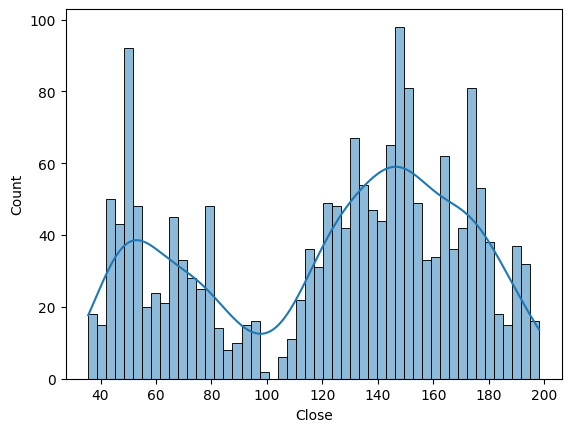

In [300]:
import seaborn as sns
def histogram_plot(df: pd.DataFrame,  **kwargs):
    """
    Plots a histogram of the data.
    """
    column = kwargs.get('column', 'Adj Close')
    sns.histplot(df[column], bins=50, kde=True)


histogram_plot(df1, column='Close')

In [301]:
df1['return'] = df1['Adj Close'].pct_change()


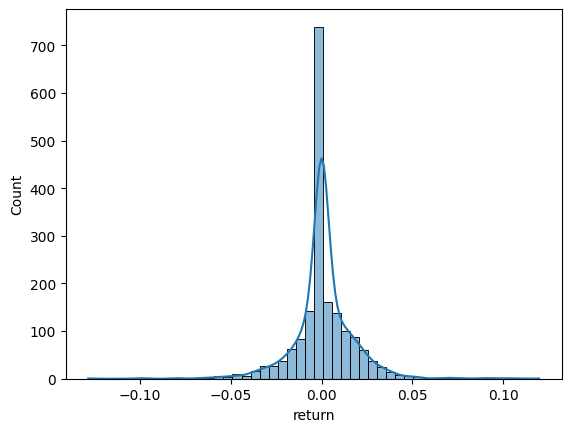

In [302]:

histogram_plot(df1, column='return')

In [303]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler 

In [309]:
if 'return' in df1.columns:
    print("Hello")

AttributeError: 'Index' object has no attribute 'lower'

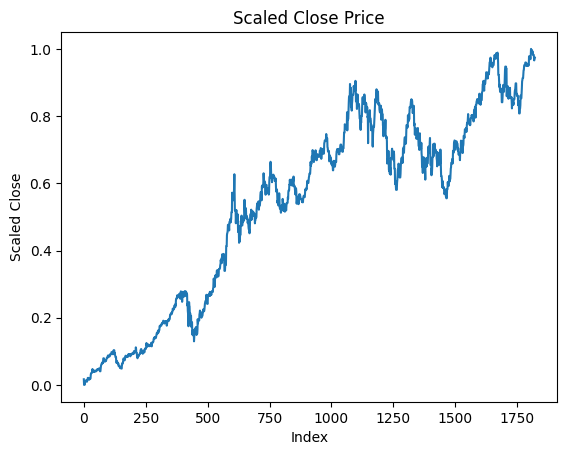

In [318]:
# calling column seclector from sklearn 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Define the scalers
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()

# Column transformer setup
col_trans = ColumnTransformer([
    ('StandardScaler', scaler1, ['return']),
    ('MinMaxScaler', scaler2, ['Open', 'High', 'Low', 'Close', 'Volume'])
], remainder='passthrough')

# Apply the transformation
transfer_data = col_trans.fit_transform(df1)

# Convert the result back to a DataFrame
transformed_df = pd.DataFrame(transfer_data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'return'])

# Plot the transformed 'Close' column
transformed_df['Open'].plot()
plt.xlabel('Index')
plt.ylabel('Scaled Close')
plt.title('Scaled Close Price')
plt.show()


In [319]:
transformed_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,return
0,NaN,0.016834,0.020115,0.018932,0.024191,0.308378,37.845043,2019.0
1,-5.962870,0.000000,0.000000,0.000000,0.000000,0.847784,34.075394,2019.0
2,2.467907,0.000849,0.004335,0.002786,0.009335,0.522733,35.530056,2019.0
3,-0.061351,0.000849,0.004335,0.002786,0.009335,0.522733,35.530056,2019.0
4,-0.061351,0.000849,0.004335,0.002786,0.009335,0.522733,35.530056,2019.0


In [ ]:
def get_scaler(df: pd.DataFrame, **kwargs):
    """
    Returns a scaler object for the data.
    """
    if 'return' in df.columns:
        scaler = StandardScaler()
        return scaler.fit(df['return'].values.reshape(-1, 1))

    elif 'Close' in df.columns:

    else:
        pass
    column = kwargs.get('column', 'Adj Close')
    scaler = MinMaxScaler()
    return scaler.fit(df[column].values.reshape(-1, 1))

In [329]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt


In [9]:
def get_stats(dataset: pd.DataFrame):
    """
    Returns descriptive statistics for the dataset.

    Args:
        dataset (pd.DataFrame): The dataset to analyze.

    Returns:
        dict: A dictionary containing the calculated statistics:
            - maxChangepercent
            - year5Changepercent
            - year2Changepercent
            - year1Changepercent
            - month6Changepercent
            - month3Changepercent
            - month1Changepercent
            - day5Changepercent
            - day30Changepercent
    """

    if 'Adj Close' in dataset.columns:
        dataset['return'] = dataset['Adj Close'].pct_change()
    else:
        dataset['return'] = dataset['Close'].pct_change()

    # Get MaxChangepercent
    maxChangepercent = dataset['return'].max()

    # Define the time periods in days (approximations)
    time_periods = {
        'year5Changepercent': 252 * 5,
        'year2Changepercent': 252 * 2,
        'year1Changepercent': 252,
        'month6Changepercent': 21 * 6,
        'month3Changepercent': 21 * 3,
        'month1Changepercent': 21,
        'day30Changepercent': 30,
        'day5Changepercent': 5
    }

    stats = {'maxChangepercent': maxChangepercent}

    # Calculate rolling means for each time period if enough data is available
    for key, period in time_periods.items():
        if len(dataset) >= period:
            value = dataset['return'].rolling(period).mean().iloc[-1]
            print(value)
            stats[key] = f"{value * 100:.5f}%"
        else:
            stats[key] = 'Not enough data points'

    # Format maxChangepercent in percentage
    stats['maxChangepercent'] = f"{stats['maxChangepercent'] * 100:.3f}%"

    return stats



In [14]:
df = yf.download('AAPL', start='2016-01-01', end='2023-12-31', interval='1D')
df_keys = get_stats(df)

[*********************100%%**********************]  1 of 1 completed

0.0015055335364521645
0.00033037619744483995
0.0017868471589326115
3.204306665016346e-05
0.0019329472381183791
0.0008256306184326283
0.0008229790070471236
-0.0022136487405562066


In [17]:
print(df_keys.keys())

dict_keys(['maxChangepercent', 'year5Changepercent', 'year2Changepercent', 'year1Changepercent', 'month6Changepercent', 'month3Changepercent', 'month1Changepercent', 'day30Changepercent', 'day5Changepercent'])


In [33]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

def get_stock_stats(stock_data: pd.DataFrame) -> dict:
    """
    Calculate percentage changes for different time periods.
    
    Parameters:
    - stock_data: pd.DataFrame containing stock data with 'Adj Close' or 'Close' columns.
    
    Returns:
    - changes: dict containing percentage changes for specified periods.
    """
    
    periods = {
        'year5': 5 * 252,
        'year2': 2 * 252,
        'year1': 252,
        'month6': 6 * 21,
        'month3': 3 * 21,
        'month1': 21,
        'day30': 30,
        'day5': 5
    }

    changes = {}
    column_name = 'Adj Close' if 'Adj Close' in stock_data.columns else 'Close'
    stock_data = stock_data[column_name]

    # Calculate max change percentage
    max_price = stock_data.max()
    min_price = stock_data.min()
    latest_close = stock_data.iloc[-1]

    changes['maxChangepercent'] = ((max_price - min_price) / min_price) * 100

    # Calculate change percentages for each period
    for period_name, period_days in periods.items():
        period_days = min(period_days, len(stock_data))  # Ensure we do not exceed available data
        past_close = stock_data.iloc[-period_days] if period_days > 0 else latest_close
        changes[f'{period_name}Changepercent'] = ((latest_close - past_close) / past_close) * 100

    return changes

# Example usage
ticker = 'AAPL'  # Replace with your desired stock ticker
stock_data = yf.download(ticker, period='2y')
stock_changes = get_stock_stats(stock_data)
print(stock_changes)


[*********************100%%**********************]  1 of 1 completed

{'maxChangepercent': 74.73604120318032, 'year5Changepercent': 51.60739087382639, 'year2Changepercent': 51.60739087382639, 'year1Changepercent': 14.362663449915896, 'month6Changepercent': 9.371177808017398, 'month3Changepercent': 24.46732417190292, 'month1Changepercent': 13.636766691423006, 'day30Changepercent': 16.01441770069517, 'day5Changepercent': -1.9871708421700904}


In [71]:
# list of crypto tickers 

crypto = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD', 'XLM-USD', 'ADA-USD', 'TRX-USD', 'XMR-USD', 'DOGE-USD', 'DASH-USD']

df = yf.download(crypto, start='2016-01-01', end='2023-12-31', interval='1D')['Close']
df1 = df.copy()
df.head()

[*********************100%%**********************]  10 of 10 completed


Ticker,ADA-USD,BTC-USD,DASH-USD,DOGE-USD,ETH-USD,LTC-USD,TRX-USD,XLM-USD,XMR-USD,XRP-USD
Date,,,,,,,,,,
2016-01-01,NaN,434.334015,NaN,NaN,NaN,3.50898,NaN,NaN,NaN,NaN
2016-01-02,NaN,433.437988,NaN,NaN,NaN,3.50216,NaN,NaN,NaN,NaN
2016-01-03,NaN,430.010986,NaN,NaN,NaN,3.48307,NaN,NaN,NaN,NaN
2016-01-04,NaN,433.091003,NaN,NaN,NaN,3.49539,NaN,NaN,NaN,NaN
2016-01-05,NaN,431.959991,NaN,NaN,NaN,3.46967,NaN,NaN,NaN,NaN


In [72]:
df1.dropna(inplace=True)
df1.head()

Ticker,ADA-USD,BTC-USD,DASH-USD,DOGE-USD,ETH-USD,LTC-USD,TRX-USD,XLM-USD,XMR-USD,XRP-USD
Date,,,,,,,,,,
2017-11-09,0.032053,7143.580078,326.007996,0.001415,320.884003,64.269699,0.002344,0.039946,120.779999,0.217488
2017-11-10,0.027119,6618.140137,329.571014,0.001163,299.252991,59.260101,0.002013,0.033073,105.585999,0.206483
2017-11-11,0.027437,6357.600098,346.056000,0.001201,314.681000,62.303299,0.002003,0.033053,119.615997,0.210430
2017-11-12,0.023977,5950.069824,536.116028,0.001038,307.907990,59.005402,0.001783,0.028182,123.856003,0.197339
2017-11-13,0.025808,6559.490234,427.372986,0.001211,316.716003,61.396500,0.002112,0.030656,123.402000,0.203442


In [75]:
my_columns = ['index', 'Stock', 'Price', 'One year return']
new_df = pd.DataFrame(columns=my_columns)

In [78]:
new_df['Stock'] = df1.columns

for i in range(len(df1.columns)):
    new_df.iloc[i, 0] = i
    print(i)



0
1
2
3
4
5
6
7
8
9


In [82]:
df1.iloc[-1]

Ticker
ADA-USD         0.601964
BTC-USD     42156.902344
DASH-USD       32.946571
DOGE-USD        0.090148
ETH-USD      2292.065430
LTC-USD        73.312737
TRX-USD         0.105985
XLM-USD         0.132611
XMR-USD       165.771484
XRP-USD         0.621844
Name: 2023-12-30 00:00:00, dtype: float64

In [88]:
stock_list = []
last_close = []
for i in range(len(df1.columns)):
    stock_list.append(df1.columns[i]), last_close.append(df1.iloc[-1, i])

get_stock_stats(df1)


[0.601963996887207,
 42156.90234375,
 32.946571350097656,
 0.09014800190925598,
 2292.0654296875,
 73.31273651123047,
 0.10598500072956085,
 0.1326110064983368,
 165.771484375,
 0.6218439936637878]

In [189]:
def get_return(df: pd.DataFrame, years: int = 1):

    timeperiod = 252 * years
    if timeperiod <= len(df):
        lastes_close = df.iloc[-1]
        past_close = df.iloc[-timeperiod]
    else:
        print('Not enough data points : available data points = ' + str(len(df)/252))

    stock_retun = (lastes_close - past_close) / past_close * 100

    new_df = pd.DataFrame(columns=df.columns)

    new_df.loc[0] = df.columns
    new_df.loc[2] = df.iloc[-1]
    new_df.loc[1] = stock_retun
    new_df = new_df.T
    new_df.columns = ['Assets', 'Last close', 'One year return']
    new_df.reset_index(inplace=True, drop=True)

    return new_df

return_hist = get_return(df1, 1)
return_hist

,Assets,Last close,One year return
0,ADA-USD,0.601964,54.746529
1,BTC-USD,42156.902344,52.790093
2,DASH-USD,32.946571,-34.366478
3,DOGE-USD,0.090148,14.371993
4,ETH-USD,2292.06543,23.092862
5,LTC-USD,73.312737,-15.632918
6,TRX-USD,0.105985,58.952871
7,XLM-USD,0.132611,40.220791
8,XMR-USD,165.771484,5.342547
9,XRP-USD,0.621844,33.725288


In [191]:
return_hist.sort_values('One year return', ascending=False, inplace=True)

In [192]:
return_hist

,Assets,Last close,One year return
6,TRX-USD,0.105985,58.952871
0,ADA-USD,0.601964,54.746529
1,BTC-USD,42156.902344,52.790093
7,XLM-USD,0.132611,40.220791
9,XRP-USD,0.621844,33.725288
4,ETH-USD,2292.06543,23.092862
3,DOGE-USD,0.090148,14.371993
8,XMR-USD,165.771484,5.342547
5,LTC-USD,73.312737,-15.632918
2,DASH-USD,32.946571,-34.366478


In [244]:
def portfolio_input():
    portfolio_size = input("Enter the value of your portfolio:")

    try:
        float(portfolio_size)
    except ValueError:
        print("That's not a number! \n Try again:")
        portfolio_size = input("Enter the value of your portfolio:")
    return portfolio_size

def position_size():
    
    position_size = float(portfolio_value) / len(df1.columns)
    
    return position_size

portfolio_value = float(portfolio_input())
position_size = position_size()

In [261]:
import math
return_hist['Number of Share to buy'] = (position_size // return_hist['Last close']).astype('int64')
return_hist

,Assets,Last close,One year return,Number of Share to buy
6,TRX-USD,0.105985,58.952871,9435
0,ADA-USD,0.601964,54.746529,1661
1,BTC-USD,42156.902344,52.790093,0
7,XLM-USD,0.132611,40.220791,7540
9,XRP-USD,0.621844,33.725288,1608
4,ETH-USD,2292.06543,23.092862,0
3,DOGE-USD,0.090148,14.371993,11092
8,XMR-USD,165.771484,5.342547,6
5,LTC-USD,73.312737,-15.632918,13
2,DASH-USD,32.946571,-34.366478,30


In [254]:
return_hist[]

,Assets,Last close,One year return,Number of Share to buy
6,TRX-USD,0.105985,58.952871,9435.297383
0,ADA-USD,0.601964,54.746529,1661.228919
1,BTC-USD,42156.902344,52.790093,0.023721
7,XLM-USD,0.132611,40.220791,7540.852199
9,XRP-USD,0.621844,33.725288,1608.120381
4,ETH-USD,2292.06543,23.092862,0.436288
3,DOGE-USD,0.090148,14.371993,11092.869269
8,XMR-USD,165.771484,5.342547,6.032401
5,LTC-USD,73.312737,-15.632918,13.640195
2,DASH-USD,32.946571,-34.366478,30.352172


In [249]:
for i in range(len(new_df.index)):
    print(new_df.loc[i ,'Number of Share to buy'] == (position_size / new_df.iloc[i, 1]))

TypeError: unsupported operand type(s) for /: 'float' and 'str'

,index,Stock,Price,One year return,Number of Share to buy
0,0,ADA-USD,NaN,NaN,0
1,1,BTC-USD,NaN,NaN,0
2,2,DASH-USD,NaN,NaN,0
3,3,DOGE-USD,NaN,NaN,0
4,4,ETH-USD,NaN,NaN,0
5,5,LTC-USD,NaN,NaN,0
6,6,TRX-USD,NaN,NaN,0
7,7,XLM-USD,NaN,NaN,0
8,8,XMR-USD,NaN,NaN,0
9,9,XRP-USD,NaN,NaN,0


In [276]:
df1

Ticker,ADA-USD,BTC-USD,DASH-USD,DOGE-USD,ETH-USD,LTC-USD,TRX-USD,XLM-USD,XMR-USD,XRP-USD
Date,,,,,,,,,,
2017-11-09,0.032053,7143.580078,326.007996,0.001415,320.884003,64.269699,0.002344,0.039946,120.779999,0.217488
2017-11-10,0.027119,6618.140137,329.571014,0.001163,299.252991,59.260101,0.002013,0.033073,105.585999,0.206483
2017-11-11,0.027437,6357.600098,346.056000,0.001201,314.681000,62.303299,0.002003,0.033053,119.615997,0.210430
2017-11-12,0.023977,5950.069824,536.116028,0.001038,307.907990,59.005402,0.001783,0.028182,123.856003,0.197339
2017-11-13,0.025808,6559.490234,427.372986,0.001211,316.716003,61.396500,0.002112,0.030656,123.402000,0.203442
...,...,...,...,...,...,...,...,...,...,...
2023-12-26,0.608799,42520.402344,36.170387,0.091356,2231.465332,73.150520,0.103069,0.126002,174.092911,0.622369
2023-12-27,0.633535,43442.855469,38.391033,0.093579,2378.739990,75.850304,0.105409,0.130853,175.491974,0.634856
2023-12-28,0.617422,42627.855469,36.893234,0.091884,2347.566162,76.722328,0.105600,0.132362,175.264069,0.634998


In [321]:
ticker_list =  ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'JPM', 'BAC', 'V', 'MA', 'PG', 'KO', 'WMT', 'PEP', 'JNJ', 'UNH', 'PFE', 'ABBV', 'LLY']
ticker_df = yf.download(ticker_list, start='2016-01-01', end='2023-12-31', interval='1D')['Adj Close']

[*********************100%%**********************]  18 of 18 completed


In [322]:
ticker_df

Ticker,AAPL,ABBV,AMZN,BAC,GOOG,JNJ,JPM,KO,LLY,MA,MSFT,PEP,PFE,PG,TSLA,UNH,V,WMT
Date,,,,,,,,,,,,,,,,,,
2016-01-04,26.337500,57.610001,31.849501,16.430000,37.091999,100.480003,63.619999,42.400002,82.870003,94.809998,54.799999,98.769997,30.313093,78.370003,14.894000,116.459999,75.699997,20.486668
2016-01-05,25.677500,57.369999,31.689501,16.430000,37.129002,100.900002,63.730000,42.549999,84.110001,94.989998,55.049999,99.449997,30.531309,78.620003,14.895333,116.680000,76.269997,20.973333
2016-01-06,25.174999,57.380001,31.632500,16.080000,37.181000,100.389999,62.810001,42.320000,83.580002,93.349998,54.049999,99.480003,29.990513,77.860001,14.602667,115.489998,75.269997,21.183332
2016-01-07,24.112499,57.209999,30.396999,15.500000,36.319500,99.220001,60.270000,41.619999,81.410004,91.639999,52.169998,97.570000,29.791271,77.180000,14.376667,112.089996,73.790001,21.676666
2016-01-08,24.240000,55.650002,30.352501,15.200000,35.723499,98.160004,58.919998,41.509998,81.250000,89.889999,52.330002,97.209999,29.411764,75.970001,14.066667,110.160004,72.879997,21.180000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,193.600006,154.940002,153.419998,33.430000,142.720001,155.460007,167.399994,58.320000,570.390015,424.100006,374.579987,167.679993,28.400000,145.279999,252.539993,520.309998,258.429993,52.216667
2023-12-26,193.050003,154.619995,153.410004,33.860001,142.820007,156.139999,168.389999,58.560001,570.669983,423.670013,374.660004,168.860001,28.410000,145.940002,256.609985,520.030029,259.160004,52.136665
2023-12-27,193.149994,154.880005,153.339996,33.840000,141.440002,156.350006,169.399994,58.709999,581.510010,424.359985,374.070007,169.399994,28.610001,146.059998,261.440002,522.789978,258.929993,52.626667


In [367]:
def get_stats(stock_data):

    periods = {
        'year5': 5 * 252,
        'year2': 2 * 252,
        'year1': 252,
        'month6': 6 * 21,
        'month3': 3 * 21,
        'month1': 21,
        'day30': 30,
        'day5': 5
    }
        

    changes = {}
    # column_name = 'Adj Close' if 'Adj Close' in stock_data.columns else 'Close'
    # column_name = stock_data.columns
    # stock_data = stock_data[column_name]

    # Calculate max change percentage
    max_price = stock_data.max()
    min_price = stock_data.min()
    latest_close = stock_data.iloc[-1]

    changes['maxChangepercent'] = ((max_price - min_price) / min_price) * 100

    # Calculate change percentages for each period
    for period_name, period_days in periods.items():
        period_days = min(period_days, len(stock_data))  # Ensure we do not exceed available data
        past_close = stock_data.iloc[-period_days] if period_days > 0 else latest_close
        changes[f'{period_name}Changepercent'] = ((latest_close - past_close) / past_close) * 100

    dataframe = pd.DataFrame.from_dict(changes)


    return dataframe
        

In [368]:
get_stats(ticker_df)

,maxChangepercent,year5Changepercent,year2Changepercent,year1Changepercent,month6Changepercent,month3Changepercent,month1Changepercent,day30Changepercent,day5Changepercent
Ticker,,,,,,,,,
AAPL,777.175154,392.939907,7.330803,48.545635,0.036367,10.808632,1.358253,1.486475,-0.552690
ABBV,241.852297,70.072428,14.487294,-4.669043,14.784096,4.532884,8.834891,12.069715,0.019362
AMZN,674.039010,105.599384,-10.201477,80.494181,16.679466,17.364433,4.004385,6.378212,-0.964669
BAC,342.473134,38.048376,-24.557478,1.599272,15.308210,26.104858,10.429644,13.981033,0.717912
GOOG,351.049016,171.782297,-3.805008,58.437322,16.896148,4.261297,5.234464,1.607784,-1.254210
JNJ,94.266313,23.155504,-8.633050,-11.725610,-4.046526,1.024822,1.344887,4.423717,0.823362
JPM,223.685698,75.668701,7.278008,27.683534,16.022103,18.313974,8.982576,12.314301,1.612911
KO,76.277946,24.851694,-0.033928,-7.849883,-2.723674,6.218459,0.838470,3.114608,1.045954
LLY,838.502340,410.437827,109.367127,58.825132,26.331751,8.291071,-1.373849,-0.990236,2.196737


In [ ]:
def get_price_poistion():
    

In [332]:
hist_ = get_stats(ticker_df).sort_values('month3Changepercent', ascending=False)

In [305]:
hqm_df = pd.DataFrame.from_dict(get_stats(df1))


<Axes: xlabel='Ticker'>

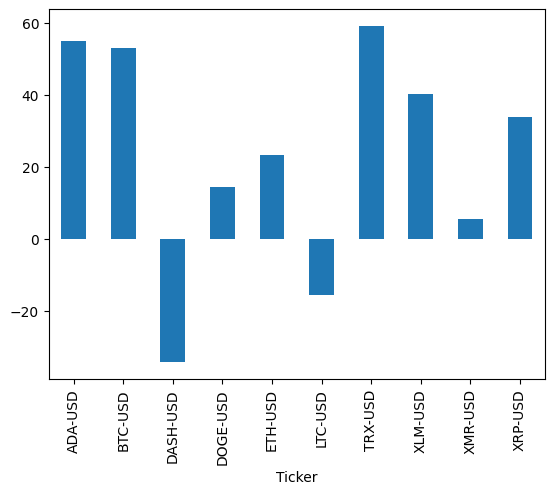

In [313]:
hqm_df['year1Changepercent'].plot(kind='bar')

In [283]:
tickers = yf.download(['AAPL', 'MSFT', 'GOOG', 'AMZN'], start='2020-01-01', end='2020-12-31')['Close']

[*********************100%%**********************]  4 of 4 completed


In [286]:
tickers

Index(['AAPL', 'AMZN', 'GOOG', 'MSFT'], dtype='object', name='Ticker')

In [362]:
class HQM:

    def __init__(self, stock_data):
        self.stock_data = stock_data

    def get_stats(self):
        periods = {
        'year5': 5 * 252,
        'year2': 2 * 252,
        'year1': 252,
        'month6': 6 * 21,
        'month3': 3 * 21,
        'month1': 21,
        'day30': 30,
        'day5': 5
    }
        

        changes = {}
        # stock_columns = self.stock_data.columns
        # print(stock_columns)
        # stock_data = stock_data[stock_columns]

        # Calculate max change percentage
        max_price = stock_data.max()
        print(max_price)
        min_price = stock_data.min()
        latest_close = stock_data.iloc[-1]

        changes['maxChangepercent'] = ((max_price - min_price) / min_price) * 100

        # Calculate change percentages for each period
        for period_name, period_days in periods.items():
            period_days = min(period_days, len(stock_data))  # Ensure we do not exceed available data
            past_close = stock_data.iloc[-period_days] if period_days > 0 else latest_close
            changes[f'{period_name}Changepercent'] = ((latest_close - past_close) / past_close) * 100

        dataframe = pd.DataFrame.from_dict(changes)

        return dataframe
            
        

In [366]:
clobj = HQM(ticker_df).get_stats()
clobj

Open         2.175900e+02
High         2.202000e+02
Low          2.130000e+02
Close        2.166700e+02
Adj Close    2.166700e+02
Volume       2.418051e+08
dtype: float64


,maxChangepercent,year5Changepercent,year2Changepercent,year1Changepercent,month6Changepercent,month3Changepercent,month1Changepercent,day30Changepercent,day5Changepercent
Open,72.676766,48.477491,48.477491,11.948261,5.925546,21.779910,8.765319,12.341811,-2.647980
High,72.340927,49.883723,49.883723,13.403711,7.925713,23.705940,11.361255,14.917068,-2.854533
Low,71.539022,47.807105,47.807105,11.664236,6.764856,21.917970,10.694953,13.429963,-2.881725
Close,73.308274,49.911330,49.911330,13.758519,9.083831,24.298734,13.636767,16.014418,-1.987171
Adj Close,74.736041,51.607391,51.607391,14.362663,9.371178,24.467324,13.636767,16.014418,-1.987171
Volume,905.497686,-63.829567,-63.829567,-39.272123,-30.653618,-40.624532,-36.803523,-36.496750,-65.609179
